In [378]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [380]:
customer_df = pd.read_csv('../data/clean/customer_dataset_transformed.csv')

display(customer_df.head())

/var/folders/t_/k5bhrc1x419crrfg_t8zp5nm0000gp/T/ipykernel_47065/101853793.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  customer_df = pd.read_csv('../data/clean/customer_dataset_transformed.csv')


,fullVisitorId,visit_number,hits_per_visit,bounced,time_on_site,totals_transactionRevenue,log_transactionRevenue,day_of_week,month,channelGrouping,device_category,country,is_weekend,is_holiday_season
0,59488412965267,1,1,1.0,0,0,0.0,2,2,2,1,213,0.0,0.0
1,85840370633780,1,2,0.0,13,0,0.0,4,9,4,0,213,0.0,0.0
2,118334805178127,1,1,1.0,0,0,0.0,4,10,3,1,213,0.0,0.0
3,166374699289385,1,5,0.0,41,0,0.0,2,8,4,0,213,0.0,0.0
4,197671390269035,1,1,1.0,0,0,0.0,1,5,7,1,213,0.0,0.0


In [382]:
customer_df.shape

(813362, 14)

# Model Implementation
1. Stage 1: predicts buyers.
2. Stage 2: predicts revenue for the buyers from Stage 1.

## Stage 1: Train a Classification model to predict if a user will make a purchase 

Create a binary `purchase_flag` column (`purchase_flag = (log_transactionRevenue > 0).astype(int)`)
    - 1 if `log_transactionRevenue` > 0 (user made a purchase).
    - 0 if `log_transactionRevenue` == 0 (user didn’t make a purchase).

### Data Preparation

In [384]:
# Create the purchase_flag column
customer_df['purchase_flag'] = (customer_df['log_transactionRevenue'] > 0).astype(int)

# Check the distribution of the target variable
print(customer_df['purchase_flag'].value_counts())

purchase_flag
0    803590
1      9772
Name: count, dtype: int64


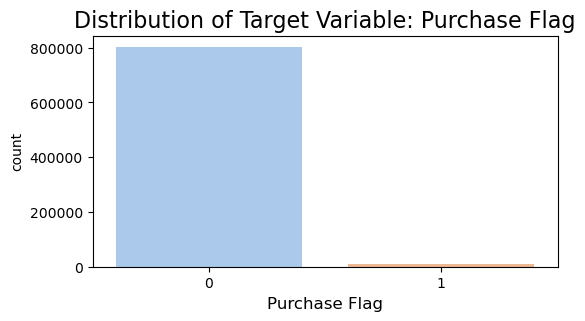

In [386]:
plt.figure(figsize=(6, 3))
sns.countplot(x='purchase_flag', data=customer_df, palette="pastel", hue='purchase_flag', legend=False)

plt.title('Distribution of Target Variable: Purchase Flag', fontsize=16)
plt.xlabel('Purchase Flag', fontsize=12)

plt.show()

There is a severe class imbalance in the dataset:
- Non-buyers (`purchase_flag` = 0): 803590 instances (~98.8% of the data).
- Buyers (`purchase_flag` = 1): 9772 instances (~1.2% of the data).

<br>

#### Handle the class imbalance identified: Oversampling the minotiry class with SMOTE
Apply **SMOTE** only to the training set (`X_train`, `y_train`), but before split the dataset:

In [396]:
from sklearn.model_selection import train_test_split

# Features and target
X = customer_df.drop(columns=['purchase_flag', 'totals_transactionRevenue'])
y = customer_df['purchase_flag']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reset indices for all partitions
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (650689, 13)
Testing set size: (162673, 13)


In [398]:
display(X_train.head())

,fullVisitorId,visit_number,hits_per_visit,bounced,time_on_site,log_transactionRevenue,day_of_week,month,channelGrouping,device_category,country,is_weekend,is_holiday_season
0,5918583838041063715,1,5,0.0,76,0.0,2,11,6,0,213,0.0,1.0
1,451525434587767360,1,1,1.0,0,0.0,0,10,7,0,163,0.0,0.0
2,5459332121352678090,1,1,1.0,0,0.0,0,11,4,0,68,0.0,1.0
3,8627190329763044165,1,1,1.0,0,0.0,5,3,7,0,92,1.0,0.0
4,6316167584035557289,1,1,1.0,0,0.0,4,1,4,1,142,0.0,0.0


##### Save a copy of the original X_train `fullVisitorId` and `log_transactionRevenue` for future reference in Stage 2

In [400]:
# Save the split datasets as CSV files for future usage (Stage 2)
X_train.to_csv('../data/clean/X_train.csv', index=False)
X_test.to_csv('../data/clean/X_test.csv', index=False)
y_train.to_csv('../data/clean/y_train.csv', index=False)
y_test.to_csv('../data/clean/y_test.csv', index=False)

In [406]:
# Remove columns not required for the model
X_train_model = X_train.drop(columns=['fullVisitorId', 'log_transactionRevenue'])
X_test_model = X_test.drop(columns=['fullVisitorId', 'log_transactionRevenue'])

In [408]:
display(X_train_model.head())

,visit_number,hits_per_visit,bounced,time_on_site,day_of_week,month,channelGrouping,device_category,country,is_weekend,is_holiday_season
0,1,5,0.0,76,2,11,6,0,213,0.0,1.0
1,1,1,1.0,0,0,10,7,0,163,0.0,0.0
2,1,1,1.0,0,0,11,4,0,68,0.0,1.0
3,1,1,1.0,0,5,3,7,0,92,1.0,0.0
4,1,1,1.0,0,4,1,4,1,142,0.0,0.0


In [419]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_model, y_train)

# Check the new class distribution
print(f"Original class distribution:\n{y_train.value_counts()}")
print(f"Resampled class distribution:\n{pd.Series(y_train_smote).value_counts()}")

Original class distribution:
purchase_flag
0    642871
1      7818
Name: count, dtype: int64
Resampled class distribution:
purchase_flag
0    642871
1    642871
Name: count, dtype: int64


<br>

### Train a **Random Forest** classifier with oversampled dataset (SMOTE applied)
Random Forest is selected as initial model due to its ability to handle categorical and numerical features without scaling.

In [425]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train a Random Forest classifier with the oversampled dataset
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [429]:
# Predict on the test set
y_pred = rf_model.predict(X_test_model)
y_pred_proba = rf_model.predict_proba(X_test_model)[:, 1]  # For ROC-AUC

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    160719
           1       0.34      0.59      0.44      1954

    accuracy                           0.98    162673
   macro avg       0.67      0.79      0.71    162673
weighted avg       0.99      0.98      0.98    162673

ROC-AUC Score: 0.9792


#### Interpretation
##### Class 1 (Buyers):
- Precision = 0.34:
    - The model struggles with precision, meaning that many users predicted as buyers are not actual buyers (high false positives).
- Recall = 0.59:
    - The model  **correctly identifies 59% of actual buyers**.
- F1-Score = 0.44:
    - Weake performance due to low precision and recall

<br>

Threshold Tuning:
Adjust the classification threshold to balance precision and recall further for buyers (class 1):

In [446]:
threshold = 0.4 #Lower the threshold to increase recall
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model with the adjusted threshold
print("Adjusted Classification Report:\n", classification_report(y_test, y_pred_adjusted))

Adjusted Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    160719
           1       0.31      0.67      0.42      1954

    accuracy                           0.98    162673
   macro avg       0.65      0.83      0.71    162673
weighted avg       0.99      0.98      0.98    162673



#### Improvement Observed:
- Precision: `0.31`: a slight drop from 0.34 earlier, due to more false positives introduced by lowering the threshold.
- Recall: `0.67`: a significant improvement from 0.59 earlier, meaning the model is identifying more true positives.
- F1-Score: `0.42`: a modest improvement, balancing precision and recall.

<br>
<br>
<br>

## Stage 2: Revenue prediction for buyers
1. Create `buyers_df` dataset
2. Train a regression model to predict revenue.

### Create `buyers_df`
The `buyers_df` dataset will include:

1. All features of the predicted buyers from `X_test`.
2. `log_transactionRevenue`, which serves as the target for the regression stage.
3. `fullVisitorId`, to maintain traceability.

In [466]:
display(X_test.head())

,fullVisitorId,visit_number,hits_per_visit,bounced,time_on_site,log_transactionRevenue,day_of_week,month,channelGrouping,device_category,country,is_weekend,is_holiday_season
0,8928058331488170793,1,19,0.0,265,0.0,1,9,4,1,213,0.0,0.0
1,4458062550870914998,1,1,1.0,0,0.0,1,12,2,1,213,0.0,1.0
2,529651714890671369,1,1,1.0,0,0.0,2,11,7,0,163,0.0,1.0
3,4796017210295787942,1,9,0.0,289,0.0,2,4,2,1,74,0.0,0.0
4,83740991903798974,1,5,0.0,146,0.0,1,8,6,0,213,0.0,0.0


#### Step 1: Add Predictions to X_test

In [468]:
# Add predictions (purchase_flag) to X_test
X_test['purchase_flag'] = y_pred

# Verify the updated X_test
print(X_test[['purchase_flag', 'fullVisitorId', 'log_transactionRevenue']].head())

   purchase_flag        fullVisitorId  log_transactionRevenue
0              0  8928058331488170793                     0.0
1              0  4458062550870914998                     0.0
2              0   529651714890671369                     0.0
3              0  4796017210295787942                     0.0
4              0    83740991903798974                     0.0


`purchase_flag` indicates whether a user was predicted as a buyer (1) or not (0)

#### Step 2: Filter for Predicted Buyers

In [485]:
# Filter for predicted buyers
buyers_df = X_test[X_test['purchase_flag'] == 1].copy()

# Verify the resulting dataset
print(f"Number of predicted buyers: {buyers_df.shape[0]}")
display(buyers_df.head())

Number of predicted buyers: 3299


,fullVisitorId,visit_number,hits_per_visit,bounced,time_on_site,log_transactionRevenue,day_of_week,month,channelGrouping,device_category,country,is_weekend,is_holiday_season,purchase_flag
5,6886097154784021033,1,11,0.0,145,0.00000,1,8,2,0,213,0.0,0.0,1
15,9483448590541822936,1,55,0.0,2016,0.00000,0,12,4,0,213,0.0,1.0,1
34,8635624610312418827,1,14,0.0,578,0.00000,1,1,2,0,213,0.0,0.0,1
50,4034062612497916684,1,34,0.0,2886,0.00000,0,4,2,0,213,0.0,0.0,1
554,2584527809923179500,1,27,0.0,355,17.50389,0,3,2,0,213,0.0,0.0,1


### Prepare Features and Target

In [482]:
# drop non-relevant columns
X_regression = buyers_df.drop(columns=['purchase_flag', 'log_transactionRevenue', 'fullVisitorId'], errors='ignore')

# Prepare target
y_regression = buyers_df['log_transactionRevenue']

# Verify the shapes
print(f"Features shape: {X_regression.shape}")
print(f"Target shape: {y_regression.shape}")


Features shape: (3299, 11)
Target shape: (3299,)


#### Split Data for Regression

In [490]:
# Split the data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

# Verify the split sizes
print(f"Training set size: {X_train_reg.shape}")
print(f"Test set size: {X_test_reg.shape}")


Training set size: (2639, 11)
Test set size: (660, 11)


### Train a **Random Forest Regression** Model

In [497]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)


RandomForestRegressor(n_estimators=200, random_state=42)

In [499]:
# Predict on the test set
y_pred_reg = rf_regressor.predict(X_test_reg)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 10.7835
R²: 0.3419


#### Analysis
- The R² score (0.3419) suggests that the model isn't explaining a substantial portion of the variance in the target variable. This is likely because predicting revenue is inherently challenging and might require additional feature engineering or a different model.
- The RMSE (10.7835) might seem high depending on the scale of `log_transactionRevenue`. It suggests that there is room for improvement in the model.